In [8]:
import numpy as np
rng = np.random.default_rng(1)
import scipy.stats as sps
import matplotlib.pyplot as plt

In [9]:
def KL(p, q): # compute Kullback-Leibler divergence (d in paper). check edge cases.
    if (p == 0 and q == 0) or (p == 1 and q == 1) or p == 0:
        return 0
    elif q == 0 or q == 1:
        return np.inf
    else:
        return p*np.log(p/q) + (1-p)*np.log((1-p)/(1-q))

In [10]:
def dKL(p, q): # derivative of KL wrt q, p is constant
    result = (p-q)/(q*(q - 1.0))
    return result

In [11]:
def newton(N, S, k, t, precision = 1e-3, max_iterations = 100, epsilon=1e-12):
    ''' Calculate upper confidence bound via newton's method 
    
        WARNING: This function works in that it efficiently finds greatest approx zero to f in (0,1).
        However, KL-UCB technically specifies that the returned value of q should be such that 
        f(q) <= 0. The q's returned by this function seemingly always satisfy f(q)>=0.
        Enforcing f(q) <= 0 does not work (times out) because f(q) converges to 0 from the right.
        If this is unacceptable, maybe look into other root finding methods like bisection.
    ''' 
    
    p = S[k]/N[k] # from paper
    delta = 0.1 # arbitrary small positive offset
    q = p + delta # initial guess. if p==q, then dKL=0 and we never move anywhere
    converged = False
    
    for n in range(max_iterations):
        if (p / q <= 0 or (1-p)/(1-q) <= 0): # sanity check for log domain errors
            print(f'log error: p={p}, q={q}, n={n}')
        # wish to find greatest val of q in (0,1) that gets f closest to zero from below
        f = KL(p, q) - np.log(t)/N[k]
        df = dKL(p, q) # derivative of f is just derivative of KL
        
        if abs(df) < epsilon: # check denominator not too small
            break 
        
        # NOTE: graph KL function to see that largest zero (what we want) is >= p.
        qnew = max(p+delta, min(q - (f / df), 1-epsilon)) # chris: my approach for keeping q in (p,1)
        # print(f'q={q}, f(q)={f}, qnew={qnew}, precision={precision} n={n}')
        if(abs(f) < precision and abs(qnew - q) < precision): # check for early convergence
            converged = True
            # print(f'converged at {n} iterations')
            break
        q = qnew
        
    # if(converged == False):
    #     print("Did not converge")

    return q

In [12]:
def KL_UCB(T, K, rwd_means):
    N = np.zeros(K) # keeps track of number of times arm k has been chosen
    S = np.zeros(K) # keeps track of cumulative sum of rewards for arm k
    # data structures just for plotting regret
    optimal_arm = np.argmax(rwd_means)
    exp_cum_rwd = [0 for t in range(T)] # exp_cum_rwd[t] is expected cumulative reward at time t
    for t in range(K):
        N[t] = 1
        S[t] = rng.uniform(rwd_means[t]-.1, rwd_means[t]+.1) # Use uniform distribution for simplicity
        exp_cum_rwd[t] = exp_cum_rwd[t-1] + rwd_means[t] if t != 0 else rwd_means[t] # t is index of chosen arm here
    for t in range(K,T):
        a = np.argmax([newton(N, S, arm, t) for arm in range(K)]) #argmax part of line 6 of algorithm 1
        r = rng.uniform(rwd_means[a]-.1, rwd_means[a]+.1)
        N[a] = N[a] + 1
        S[a] = S[a] + r
        exp_cum_rwd[t] = exp_cum_rwd[t-1] + rwd_means[a]
    optimal_exp_cum_rwd = [(t+1) * rwd_means[optimal_arm] for t in range(T)]
    regret = np.asarray(optimal_exp_cum_rwd) - np.asarray(exp_cum_rwd) # see definition of regret
    return regret

In [13]:
# run
K = 5
T = 1000
rwd_means = [.2, .3, .4, .5, .6]
optimal_arm = np.argmax(rwd_means)
regret = KL_UCB(T, 5, rwd_means)

/var/folders/16/hk9qdzp172nbtb7pj39vw7ww0000gn/T/ipykernel_95504/535199166.py:7: RuntimeWarning: divide by zero encountered in log
  theoretical_regret_bounds = [coeff * np.log(t) for t in time_axis] # not sure if allowed to do this bc of lim sup, seems like it works tho


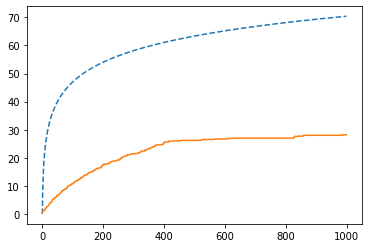

In [14]:
# plotting
time_axis = list(range(T))
# plot theoretical regret bounds
coeff = 0
for i in range(K):
    if (i != optimal_arm): coeff += (rwd_means[optimal_arm] - rwd_means[i]) / (KL(rwd_means[i], rwd_means[optimal_arm]))
theoretical_regret_bounds = [coeff * np.log(t) for t in time_axis] # not sure if allowed to do this bc of lim sup, seems like it works tho
plt.plot(time_axis, theoretical_regret_bounds, '--')
plt.plot(time_axis, regret)